# T cell clustering and markers

In this notebook, we use marker gene detection to select clusters that contain T cells, then subset our dataset and perform a round of iterative clustering at multiple resolutions. At each resolution we identify marker genes, then generate plots that we can use to assess cell type identity.

The outputs of this analysis are used by our domain experts to assign cell type identities to our reference. 

## Load packages

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import copy
from datetime import date
import hisepy
import os
import pandas as pd 
import re
import scanpy as sc
import scanpy.external as sce

## Helper functions

These functions will help with subsetting and performing leiden clustering at multiple resolutions in parallel.

`select_clusters_by_gene_frac()` allows us to compute the fraction of cells in each cluster that express the provided gene (> 0 UMIs). This fraction is provided by `scanpy`'s dotplot function, which calculates these fractions for use in display. We then filter clusters based on the cutoff provided as a parameter to this function.

`run_leiden()` and `run_leiden_parallel()` enable parallel computation of multiple resolutions of leiden clustering.

In [2]:
def select_clusters_by_gene_frac(adata, gene, cutoff, clusters = 'leiden'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = gene,
        return_fig = True
    ).dot_size_df

    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

def run_leiden(adata, resolution, key_added):
    # Make a copy of adata for thread safety
    adata_copy = copy.deepcopy(adata)
    adata_clustering = sc.tl.leiden(
        adata_copy, 
        resolution = resolution, 
        key_added = key_added, 
        copy = True)
    return adata_clustering.obs

def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers = 5) as executor:
        # Make deep copies of adata for each task to ensure thread safety
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        
        results = [future.result() for future in futures]

    # Assign the results back to the original AnnData object
    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]

    return adata

## Read full dataset from HISE

In [3]:
cell_class = 't-cells'

In [4]:
h5ad_uuid = '9db48bed-cd91-49ae-abd2-447ae478ca96'
h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)

In [5]:
if not os.path.isdir(h5ad_path):
    hise_res = hisepy.reader.cache_files([h5ad_uuid])

In [6]:
h5ad_filename = os.listdir(h5ad_path)[0]
h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)

In [7]:
adata = sc.read_h5ad(h5ad_file)

In [8]:
adata

AnnData object with n_obs × n_vars = 1952128 × 1236
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'file.id', 'subject.cmv', 'subject.bmi', 'celltypist.low', 'seurat.l1', 'seurat.l1.score', 'seurat.l2', 'seurat.l2.score', 'seurat.l2.5', 'seurat.l2.5.score', 'seurat.l3', 'seurat.l3.score', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden'
    var: 'mito', 'n_cells_by_counts

## Plot major cell class markers

To get an overview of cluster identity, we'll use a set of marker genes that are expressed in major classes of PBMC cell types:

In [9]:
markers = [
    'MS4A1', # B cells
    'CD3D',  # T cells
    'NCAM1', # NK cells
    'FCN1',  # Myeloid cells
    'HBB',   # Erythrocytes
    'PPBP',  # Platelets
    'MKI67', # Proliferating cells
    'IL3RA'  # pDCs
]

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


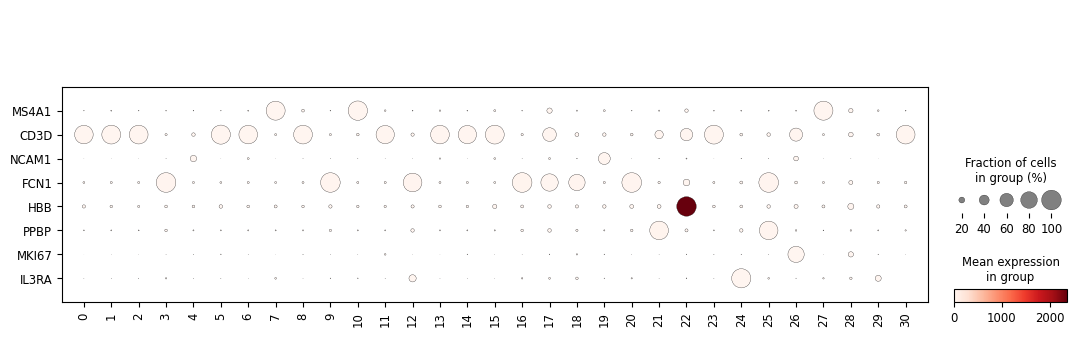

In [10]:
sc.pl.dotplot(
    adata, 
    groupby = 'leiden',
    var_names = markers,
    swap_axes = True
)

## Select clusters to retain

To select clusters, we'll use `select_clusters_by_gene_frac()` to select clusters for our desired cell type. We can also select clusters that express off-target genes (like HBB and PPBP), and use these to filter our list of clusters.

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


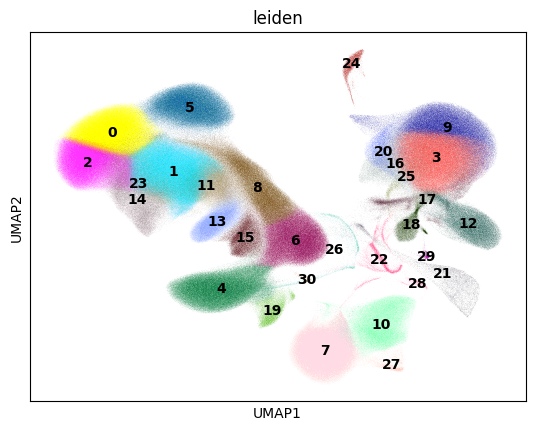

In [11]:
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


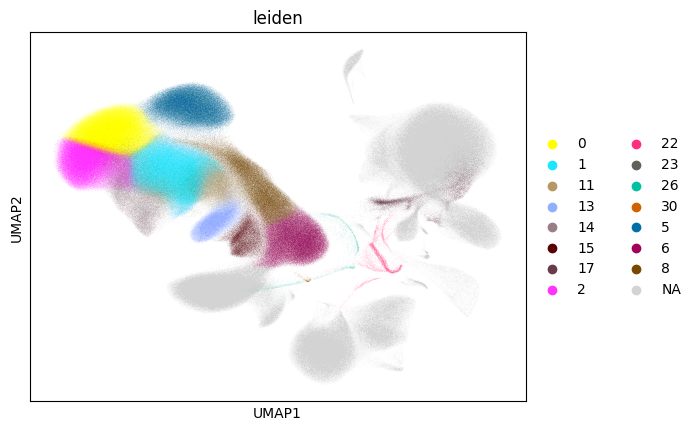

In [12]:
cd3_pos_cl = select_clusters_by_gene_frac(
    adata, gene = 'CD3D', cutoff = 0.5, clusters = 'leiden'
)
sc.pl.umap(adata, color = 'leiden', groups = cd3_pos_cl)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


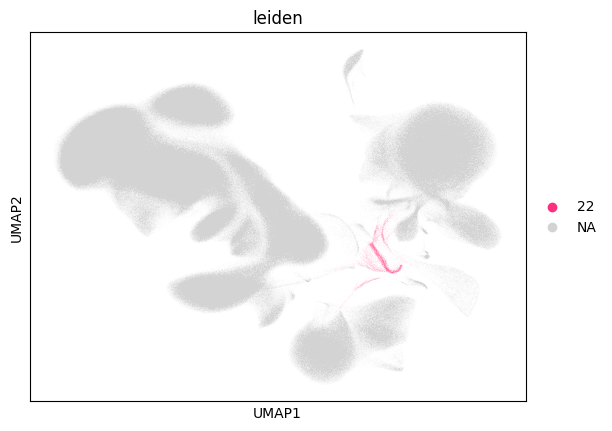

In [13]:
hbb_pos_cl = select_clusters_by_gene_frac(
    adata, gene = 'HBB', cutoff = 0.8, clusters = 'leiden'
)
sc.pl.umap(adata, color = 'leiden', groups = hbb_pos_cl)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


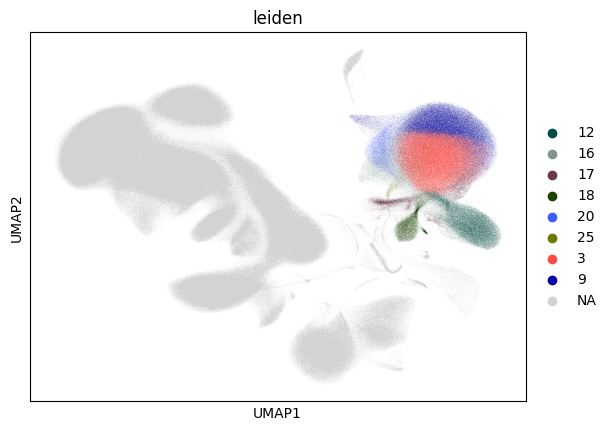

In [14]:
fcn1_pos_cl = select_clusters_by_gene_frac(
    adata, gene = 'FCN1', cutoff = 0.5, clusters = 'leiden'
)
sc.pl.umap(adata, color = 'leiden', groups = fcn1_pos_cl)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


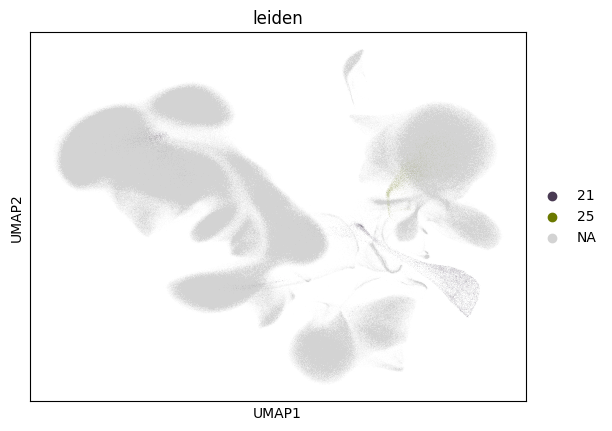

In [15]:
ppbp_pos_cl = select_clusters_by_gene_frac(
    adata, gene = 'PPBP', cutoff = 0.6, clusters = 'leiden'
)
sc.pl.umap(adata, color = 'leiden', groups = ppbp_pos_cl)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


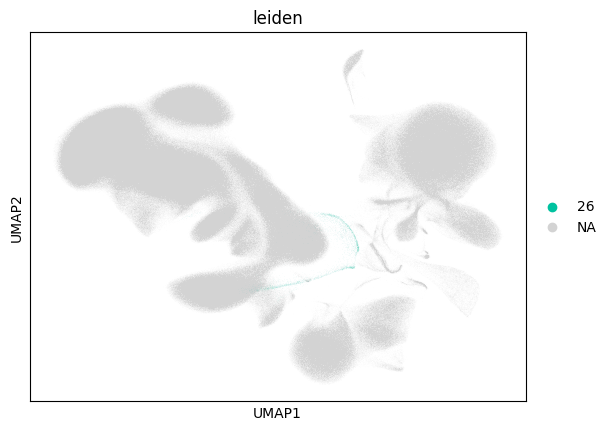

In [16]:
mki67_pos_cl = select_clusters_by_gene_frac(
    adata, gene = 'MKI67', cutoff = 0.4, clusters = 'leiden'
)
sc.pl.umap(adata, color = 'leiden', groups = mki67_pos_cl)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


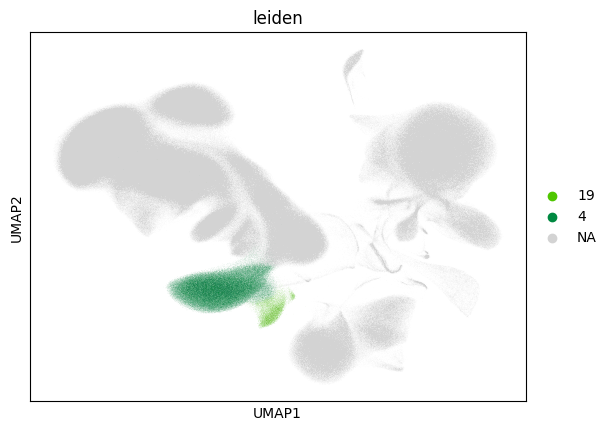

In [17]:
ncam1_pos_cl = select_clusters_by_gene_frac(
    adata, gene = 'NCAM1', cutoff = 0.2, clusters = 'leiden'
)
sc.pl.umap(adata, color = 'leiden', groups = ncam1_pos_cl)

## Select clusters and subset data

Here, we use Python's `set` class to keep the clusters we want, and remove off-target hits.

In [18]:
keep_cl = set(cd3_pos_cl) - set(hbb_pos_cl)
keep_cl = keep_cl - set(ppbp_pos_cl)
keep_cl = keep_cl - set(fcn1_pos_cl)
keep_cl = list(keep_cl)
keep_cl.sort()
keep_cl

['0', '1', '11', '13', '14', '15', '2', '23', '26', '30', '5', '6', '8']

Now, we can filter the dataset to get the subset we're after.

In [19]:
adata_subset = adata[adata.obs['leiden'].isin(keep_cl)]

In [20]:
adata_subset.shape

(1191327, 1236)

## Normalize and harmonize subset

As in the original analysis of this dataset, we'll need to normalize, select marker genes, and run Harmony to integrate across our cohorts.

It's important that we redo this step for our subset, as gene variability may differ when computed within our subset of cells rather than across the entire set of PBMCs. This key feature selection step will affect our ability to cluster and identify cell types, so we do this iteratively for the subset we're using now.

We previously stored raw counts in `adata.raw` - we can now recover these original count data for analysis of the selected cells:

In [21]:
adata_subset = adata_subset.raw.to_adata()

In [22]:
adata_subset.shape

(1191327, 33538)

In [23]:
adata_subset.raw = adata_subset

In [24]:
sc.pp.normalize_total(adata_subset, target_sum=1e4)

In [25]:
sc.pp.log1p(adata_subset)
sc.pp.highly_variable_genes(adata_subset)
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]]

In [26]:
sc.pp.scale(adata_subset)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [27]:
sc.tl.pca(adata_subset, svd_solver='arpack')

In [28]:
sce.pp.harmony_integrate(
    adata_subset, 
    'cohort.cohortGuid',
    max_iter_harmony = 30)

2024-02-21 18:56:06,271 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-02-21 19:01:32,684 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-02-21 19:01:37,020 - harmonypy - INFO - Iteration 1 of 30
2024-02-21 19:08:47,040 - harmonypy - INFO - Iteration 2 of 30
2024-02-21 19:16:14,170 - harmonypy - INFO - Iteration 3 of 30
2024-02-21 19:23:32,080 - harmonypy - INFO - Converged after 3 iterations


In [29]:
sc.pp.neighbors(
    adata_subset, 
    n_neighbors = 50,
    use_rep = 'X_pca_harmony', 
    n_pcs = 30)

In [30]:
sc.tl.umap(adata_subset, min_dist = 0.05)

In [31]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [32]:
subset_h5ad = 'output/ref_pbmc_t-cells_subset_{d}.h5ad'.format(d = date.today())
adata_subset.write_h5ad(subset_h5ad)

## Cluster at multiple resolutions

Here, we use our helper functions to perform clustering at multiple resolutions. This can be helpful for finding a set of clusters that correspond well to marker expression and distinguish functional cell type differences.

In [ ]:
%%time
tasks = [
    (1, "leiden_resolution_1"),
    (1.5, "leiden_resolution_1.5"),
    (2, "leiden_resolution_2")
]
adata_subset = run_leiden_parallel(adata_subset, tasks)

In [ ]:
clustered_h5ad = 'output/ref_pbmc_{c}_clustered_{d}.h5ad'.format(c = cell_class, d = date.today())
adata_subset.write_h5ad(clustered_h5ad)

## Plot reference labels and clustering

Now that we've clustered, it's helpful to plot reference labels and clusters on our UMAP projection to see how they fall relative to each other.

In [ ]:
sc.pl.umap(
    adata_subset, 
    color = ['seurat.l2.5'], 
    size = 2,
    show = False,
    ncols = 1 ,
    frameon = False
)

In [ ]:
sc.pl.umap(
    adata_subset, 
    color = ['celltypist.low'], 
    size = 2,
    show = False,
    ncols = 1 ,
    frameon = False
)

CMV status is also helpful to view, as CMV can drive expansion of some cell types.

In [ ]:
sc.pl.umap(
    adata_subset, 
    color = ['subject.cmv'], 
    size = 2,
    show = False,
    ncols = 1 ,
    frameon = False
)

In [ ]:
leiden_cols = [t[1] for t in tasks]
sc.pl.umap(
    adata_subset, 
    color = leiden_cols, 
    size = 2,
    show = False,
    ncols = 1 ,
    frameon = False
)

## Save UMAP coordinates and labels

In [ ]:
umap_mat = adata.obsm['X_umap']

In [ ]:
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])

In [ ]:
obs = adata.obs
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [ ]:
out_csv = 'output/ref_{c}_clustered_umap_meta_{d}.csv'.format(c = cell_class, d = date.today())

In [ ]:
obs.to_csv(out_csv)

In [ ]:
out_parquet = 'output/ref_{c}_clustered_umap_meta_{d}.parquet'.format(c = cell_class, d = date.today())

In [ ]:
obs = obs.to_parquet(out_parquet)

## Compute markers for each resolution of Leiden clustering

In [ ]:
adata_subset = adata_subset.raw.to_adata()
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)

marker_files = {}
for res_num,res_name in tasks:
    res_csv = '{p}/ref_{c}_res{n}_markers_{d}.csv'.format(p = out_dir, c = cell_class, n = res_num, d = date.today())
    sc.tl.rank_genes_groups(adata_subset, res_name, method = 'wilcoxon')
    df = sc.get.rank_genes_groups_df(adata_subset, group = None)
    df.to_csv(res_csv)
    marker_files[n] = res_csv

## Plot top markers

In [ ]:
res2_marker_file = marker_files[2]
res2_markers = pandas.read_csv(res2_marker_file)

In [ ]:
res2_markers = (
    res2_markers
    .groupby('group')
    .head(20)
    .reset_index(drop=True)
)

In [ ]:
plot_file = '{p}/ref_{c}_res2_marker_plot_{d}.png'.format(p = out_dir, c = cell_class, d = date.today())

groups = df.groupby('group')

fig, axs = plt.subplots(4, 6, figsize=(10, 14), squeeze=False)

# Loop through each group and create a scatter plot in the corresponding subplot
for i, (name, group) in enumerate(groups):
    row, col = i // 6, i % 6
    axs[row, col].scatter(group['scores'], group['names'])
    axs[row, col].invert_yaxis()
    axs[row, col].set_title(str(name)+" vs Rest")
    axs[row, col].set_xlabel('U scores')
    axs[row, col].set_ylabel('Gene')
fig.tight_layout()

plt.savefig(plot_file)

## Upload assembled data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [ ]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'T cell subclustering {d}'.format(d = date.today())

In [ ]:
in_files = [h5ad_uuid]

In [ ]:
out_files = [clustered_h5ad, out_csv, out_parquet, marker_list, plot_file]

In [ ]:
import session_info
session_info.show()